Data scientist salaries analysis
===
*Author: Francisco Javier Sánchez Panduro*\
*Supervised by: Professor Doctor Brenda García Maya*\
*Monterrey Institute of Tecnology and Higher Studies*\
*13 of August 2023*

## Introduction
Using the linear regression model, we aim to predict salaries in dollars for data scientists. Using the features experience level, salary, type of job and remote radio.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

Data preparation
---

Data authored by Bhatia, n.d.

The data includes 11 columns, here explained
| Column | Description |
|---|---|
|work_year	| The year the salary was paid.|
|experience_level|	The experience level in the job during the year with the following possible values: EN Entry-level / Junior MI Mid-level / Intermediate SE Senior-level / Expert EX Executive-level / Director|
|employment_type|	The type of employement for the role: PT Part-time FT Full-time CT Contract FL Freelance|
|job_title	|The role worked in during the year.|
|salary	|The total gross salary amount paid.|
|salary_currency|	The currency of the salary paid as an ISO 4217 currency code.|
|salary_in_usd|	The salary in USD (FX rate divided by avg. USD rate for the respective year via fxdata.foorilla.com).|
|employee_residence|	Employee's primary country of residence in during the work year as an ISO 3166 country code.|
|remote_ratio|	The overall amount of work done remotely, possible values are as follows: 0 No remote work (less than 20%) 50 Partially remote 100 Fully remote (more than 80%)|
|company_location|	The country of the employer's main office or contracting branch as an ISO 3166 country code.|
|company_size|	The average number of people that worked for the company during the year: S less than 50 employees (small) M 50 to 250 employees (medium) L more than 250 employees (large)|

In [2]:
df = pd.read_csv('data/ds_salaries.csv')
df.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [3]:
print(df.shape)

(607, 12)


In [4]:
df.isnull().sum()

Unnamed: 0            0
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [5]:
# Create dataframe with only relevant data
df = pd.DataFrame({'experience_level': df['experience_level'], 'employment_type' : df['employment_type'], 'salary_in_usd' : df['salary_in_usd'], 'salary' : df['salary'], 'remote_ratio' : df['remote_ratio']})
df.head()

,experience_level,employment_type,salary_in_usd,salary,remote_ratio
0,MI,FT,79833,70000,0
1,SE,FT,260000,260000,0
2,SE,FT,109024,85000,50
3,MI,FT,20000,20000,0
4,SE,FT,150000,150000,50


In [6]:
print(df['experience_level'].unique())

['MI' 'SE' 'EN' 'EX']


In [7]:
print(df['employment_type'].unique())

['FT' 'CT' 'PT' 'FL']


In [8]:
# Create dummy variables to represent categorical data in numerical form
dummies_experience_level = pd.get_dummies(df['experience_level'], prefix='experience_level', dtype = 'uint8')
dummies_experience_level.head()

,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE
0,0,0,1,0
1,0,0,0,1
2,0,0,0,1
3,0,0,1,0
4,0,0,0,1


In [9]:
dummies_employment_type = pd.get_dummies(df['employment_type'], prefix='employment_type', dtype = 'uint8')
dummies_employment_type.head()

,employment_type_CT,employment_type_FL,employment_type_FT,employment_type_PT
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


In [10]:
df = pd.concat([df, dummies_employment_type, dummies_experience_level], axis=1)
df.drop('experience_level', axis = 1, inplace=True)
df.drop('employment_type', axis = 1, inplace=True)
df.head()

,salary_in_usd,salary,remote_ratio,employment_type_CT,employment_type_FL,employment_type_FT,employment_type_PT,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE
0,79833,70000,0,0,0,1,0,0,0,1,0
1,260000,260000,0,0,0,1,0,0,0,0,1
2,109024,85000,50,0,0,1,0,0,0,0,1
3,20000,20000,0,0,0,1,0,0,0,1,0
4,150000,150000,50,0,0,1,0,0,0,0,1


## Correlation

The following correlation matrix displays the Pearson correlation coefficients between multiple variables in the dataset. The Pearson correlation coefficient $r$ quantifies the strength and direction of the linear relationship between two variables.

A positive $r$ value indicates a positive correlation; the closer the value is to 1, the stronger the positive correlation. A negative value indicates the opposite, with the value closer to -1 indicating a stronger negative correlation.

To calculate $r$ between two variables $X$ and $Y$, the formula is:
$$
r = \frac{\sum{(X_i - \bar{X})(Y_i - \bar{Y})}}{\sqrt{\sum{(X_i - \bar{X})^2} \cdot \sum{(Y_i - \bar{Y})^2}}}
$$
Where:
- $X_i$ and $Y_i$ are individual data points for variables $X$ and $Y$.
- $ \bar{X} $ and $ \bar{Y} $ are the means of variables $X$ and $Y$.

In [11]:
correlation_matrix = df.corr()
display(correlation_matrix)

,salary_in_usd,salary,remote_ratio,employment_type_CT,employment_type_FL,employment_type_FT,employment_type_PT,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE
salary_in_usd,1.000000,-0.083906,0.132122,0.092907,-0.073863,0.091819,-0.144627,-0.294196,0.259866,-0.252024,0.343513
salary,-0.083906,1.000000,-0.014608,-0.008268,-0.014568,0.025685,-0.020006,-0.015845,0.014130,0.074626,-0.065995
remote_ratio,0.132122,-0.014608,1.000000,0.065149,-0.016865,-0.023834,-0.002935,-0.010490,0.041208,-0.127850,0.113071
employment_type_CT,0.092907,-0.008268,0.065149,1.000000,-0.007423,-0.506989,-0.011795,0.066013,0.070739,-0.028817,-0.047768
employment_type_FL,-0.073863,-0.014568,-0.016865,-0.007423,1.000000,-0.453089,-0.010541,-0.033537,-0.017229,0.068108,-0.034520
employment_type_FT,0.091819,0.025685,-0.023834,-0.506989,-0.453089,1.000000,-0.719987,-0.167828,-0.008698,-0.006597,0.128381
employment_type_PT,-0.144627,-0.020006,-0.002935,-0.011795,-0.010541,-0.719987,1.000000,0.204028,-0.027379,-0.013805,-0.119762
experience_level_EN,-0.294196,-0.015845,-0.010490,0.066013,-0.033537,-0.167828,0.204028,1.000000,-0.087108,-0.302761,-0.381033
experience_level_EX,0.259866,0.014130,0.041208,0.070739,-0.017229,-0.008698,-0.027379,-0.087108,1.000000,-0.155539,-0.195751
experience_level_MI,-0.252024,0.074626,-0.127850,-0.028817,0.068108,-0.006597,-0.013805,-0.302761,-0.155539,1.000000,-0.680373


In [12]:
# Find the high positive correlation values
high_positive_correlation = np.where((correlation_matrix > 0.95) & (correlation_matrix < 1))
# Print the index of values found
for i in high_positive_correlation:
    print(i)

[]
[]


In [13]:
# Find the high negative correlation values
high_negative_correlation = np.where((correlation_matrix < -0.95) & (correlation_matrix > -1))
# Print the index of values found
for i in high_negative_correlation:
    print(i)

[]
[]


There are no high positive or negative correlation values, which implies a low linear association and suggests that our model may have weak predictive power. There is also the possibility of other types of non-linear relationships. We will further explore linear regression in this document.

## Standardization

Standardization is performed to ensure that our machine learning algorithm treats all features equally and to minimize the impact of one feature having more influence than others simply because of differing value ranges. During standardization, the features are transformed to have a mean of 0 and a standard deviation of 1.


In [14]:
scaler = StandardScaler()
standard_values = scaler.fit_transform(df)
standard_df = pd.DataFrame(standard_values, columns = df.columns)
display(standard_df)

,salary_in_usd,salary,remote_ratio,employment_type_CT,employment_type_FL,employment_type_FT,employment_type_PT,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE
0,-0.457904,-0.164605,-1.743615,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,1.360061,-0.925348
1,2.083282,-0.041475,-1.743615,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,-0.735261,1.080674
2,-0.046177,-0.154885,-0.514377,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,-0.735261,1.080674
3,-1.301826,-0.197008,-1.743615,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,1.360061,-0.925348
4,0.531774,-0.112761,-0.514377,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,-0.735261,1.080674
...,...,...,...,...,...,...,...,...,...,...,...
602,0.588192,-0.110169,0.714862,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,-0.735261,1.080674
603,0.193263,-0.128314,0.714862,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,-0.735261,1.080674
604,0.235577,-0.126370,-1.743615,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,-0.735261,1.080674
605,0.531774,-0.112761,0.714862,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,-0.735261,1.080674


## Ordinary least squares regression model training

Ordinary least squares (OLS) regression is a method within linear regression that aims to minimze the squared residuals between the predicted values and the actual values of the dataset.

OLS regression assumes that the relationsip between the independt variables $x$ and the dependent variable $y$ can be represented by the linear equation of the form:

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_k x_k + \varepsilon
$$

Where:
- $\beta_0, \beta_1, \ldots, \beta_k$ are the coefficients to be estimated.
- $x_0, x_1, \ldots, x_k$ are the independent variables.
- $k$ represents the number of independent variables in the model
- $\varepsilon$ represents the error term.

The goal is to find the values of the coefficients that minimize the sum of squared differences between the observed values of $y$ and those predicted by the equation.

The first step is to divide the data between the data used to train the model and the data used to test it with a 80% - 20% split.
This split is randomized, which means the model and results may be different if the code is re-run.

In [15]:
training_df, testing_df = train_test_split(standard_df, test_size = 0.20)
display(training_df)
display(testing_df)

,salary_in_usd,salary,remote_ratio,employment_type_CT,employment_type_FL,employment_type_FT,employment_type_PT,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE
206,1.237005,-0.080359,0.714862,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,-0.735261,1.080674
334,0.748985,-0.102781,0.714862,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,-0.735261,1.080674
352,0.771552,-0.101744,0.714862,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,-0.735261,1.080674
468,-0.173457,-0.145164,0.714862,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,-0.735261,1.080674
363,-0.719305,-0.170243,0.714862,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,-0.735261,1.080674
...,...,...,...,...,...,...,...,...,...,...,...
537,0.602297,-0.109521,0.714862,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,-0.735261,1.080674
170,0.813866,-0.099800,0.714862,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,1.360061,-0.925348
179,-1.503818,0.062213,0.714862,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,1.360061,-0.925348
524,0.320205,-0.122482,0.714862,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,1.360061,-0.925348


,salary_in_usd,salary,remote_ratio,employment_type_CT,employment_type_FL,employment_type_FT,employment_type_PT,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE
145,-0.416846,-0.164605,-0.514377,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,-0.735261,1.080674
322,0.673948,-0.106229,-1.743615,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,-0.735261,1.080674
367,-0.765850,-0.172382,-1.743615,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,1.360061,-0.925348
150,0.785657,-0.101096,-1.743615,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,-0.735261,1.080674
34,-0.924400,-0.183399,-0.514377,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,1.360061,-0.925348
...,...,...,...,...,...,...,...,...,...,...,...
438,1.091022,-0.087066,-1.743615,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,-0.735261,1.080674
492,-1.081935,-0.112761,0.714862,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,1.360061,-0.925348
295,0.531774,-0.112761,0.714862,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,1.360061,-0.925348
45,-1.358724,-0.200896,0.714862,-0.091135,-0.081446,-5.563036,7.726578,2.428524,-0.211543,-0.735261,-0.925348


To create an Ordinary Least Squares (OLS) Regression model, we utilize the `statsmodels` library. The model is trained using the designated dataset.

The process of fitting the OLS model using the `statsmodels.formula.api.ols` method involves the following steps:

1. **Initialization of Coefficients**: The method initializes the coefficients to initial values based on the provided formula.

2. **Data Feeding**: The training data, including the independent variables (predictors) and the dependent variable (response), is provided to the model.

3. **Error Calculation**: The model calculates the difference between the actual observed values and the predicted values for each data point. These differences are known as errors or residuals.

4. **Loss Function Calculation**: The model computes the loss function, which evaluates how well the current coefficients perform. In OLS, the loss function is represented by the sum of squared residuals.

$$
\sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

5. **Optimization**: The formula is optimized to find the vector of coefficients \(\beta\) that minimizes the sum of squared residuals. This optimization is achieved by solving the normal equations:
   
   $$
   X^TX\beta = X^Ty
   $$

   Here, $X^TX$ represents the transpose of the matrix $X$ multiplied by itself, and $X^Ty$ represents the transpose of $X$ multiplied by the vector $y$.

6. **Model Fitting**: With the optimized coefficients, the model is considered "fitted." The method returns various statistics related to the model fit, including standard errors, p-values, R-squared, and more.

In [16]:
ols_model = smf.ols(formula = 'salary_in_usd ~ salary + remote_ratio + employment_type_CT + employment_type_FL + employment_type_FT + employment_type_PT + experience_level_EN + experience_level_EX + experience_level_MI + experience_level_SE',
                   data = training_df)
ols_results = ols_model.fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:          salary_in_usd   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     22.59
Date:                Sun, 13 Aug 2023   Prob (F-statistic):           2.67e-29
Time:                        15:05:37   Log-Likelihood:                -618.75
No. Observations:                 485   AIC:                             1255.
Df Residuals:                     476   BIC:                             1293.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0127    

### Interpreting the Results

We interpret the results using hypothesis testing. The null hypothesis $H_0$ states that the coefficient for a variable is zero, implying that the variable has no significant impact on the response variable. The alternative hypothesis $H_1$ posits that the coefficient is not equal to zero, suggesting a meaningful relationship.

To assess the statistical significance of a coefficient, we often use a significance level, such as 0.05, which is commonly chosen. If the calculated $p$-value associated with a coefficient is smaller than the chosen significance level, it indicates that the observed relationship between the predictor variable and the response variable is unlikely to have occurred by random chance alone. In this case, we consider the variable statistically significant.

There is a $R^2$ value of:

In [17]:
print(ols_results.rsquared)

0.2752149392926504


This means that this percent of the variability is in the dependent variable is explained by the independent variables.

### Running the model only with significant values

In [18]:
p_values = ols_results.pvalues
print(p_values)

Intercept              7.491776e-01
salary                 1.349485e-01
remote_ratio           8.805123e-02
employment_type_CT     2.166565e-04
employment_type_FL     3.920191e-02
employment_type_FT     3.991449e-01
employment_type_PT     3.471538e-02
experience_level_EN    5.800403e-13
experience_level_EX    3.604514e-12
experience_level_MI    4.556959e-06
experience_level_SE    1.011027e-13
dtype: float64


In [19]:
ols_model_refined = smf.ols(formula = 'salary_in_usd ~ ' + ' + '.join(p_values[p_values < 0.05].index), data = training_df)
ols_results_refined = ols_model_refined.fit()
print(ols_results_refined.summary())

                            OLS Regression Results                            
Dep. Variable:          salary_in_usd   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     24.82
Date:                Sun, 13 Aug 2023   Prob (F-statistic):           6.86e-29
Time:                        15:05:37   Log-Likelihood:                -621.48
No. Observations:                 485   AIC:                             1259.
Df Residuals:                     477   BIC:                             1292.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0156    

## Prediction formula

In [20]:
coefficients = ols_results_refined.params
significant_features = p_values[p_values < 0.05].index

prediction_formula = f"salary_in_usd = {coefficients['Intercept']:.2f}"

for feature in significant_features:
    coefficient = coefficients[feature]
    prediction_formula += f" + ({coefficient:.2f} * {feature})"

print(prediction_formula)

salary_in_usd = 0.02 + (0.13 * employment_type_CT) + (-0.09 * employment_type_FL) + (-0.08 * employment_type_PT) + (-1489155536207.46 * experience_level_EN) + (-856425885894.04 * experience_level_EX) + (-2018612499062.97 * experience_level_MI) + (-2108472482303.71 * experience_level_SE)


### Comparing the real results with the predicted ones

In [21]:
predicted_salaries = coefficients['Intercept'] + testing_df[significant_features].dot(coefficients[significant_features])
predicted_df = pd.DataFrame({'Real': testing_df['salary_in_usd'],'Predicted': predicted_salaries, 'Error': testing_df['salary_in_usd'] - predicted_salaries}, index=testing_df.index)
display(predicted_df)

,Real,Predicted,Error
145,-0.416846,0.396618,-0.813464
322,0.673948,0.396618,0.277331
367,-0.765850,-0.298824,-0.467027
150,0.785657,0.396618,0.389039
34,-0.924400,-0.298824,-0.625577
...,...,...,...
438,1.091022,0.396618,0.694404
492,-1.081935,-0.298824,-0.783111
295,0.531774,-0.298824,0.830598
45,-1.358724,-1.367183,0.008459


## Visualization

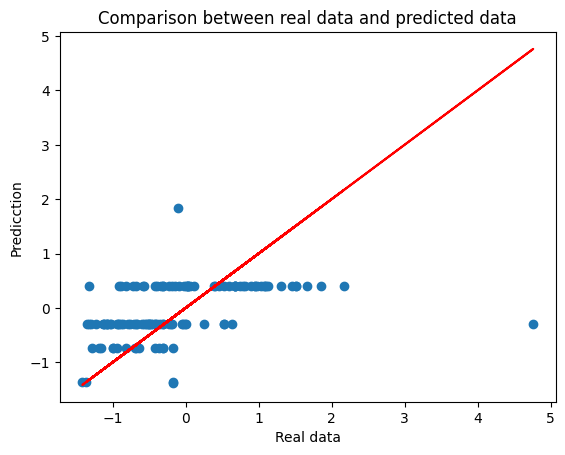

In [22]:
plt.scatter(predicted_df['Real'], predicted_df['Predicted'])
plt.plot(predicted_df['Real'], predicted_df['Real'], color = 'red')
plt.xlabel("Real data")
plt.ylabel("Predicction")
plt.title('Comparison between real data and predicted data')
plt.show()

### Errors

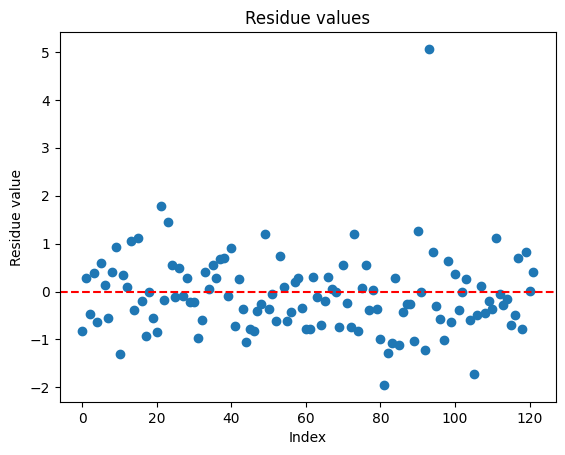

In [23]:
plt.scatter(range(len(predicted_df['Error'])), predicted_df['Error'])
plt.axhline(y = 0, linestyle = '--', color = 'red')
plt.title('Residue values')
plt.ylabel('Residue value')
plt.xlabel('Index')
plt.show()

Text(0, 0.5, 'Frequency')

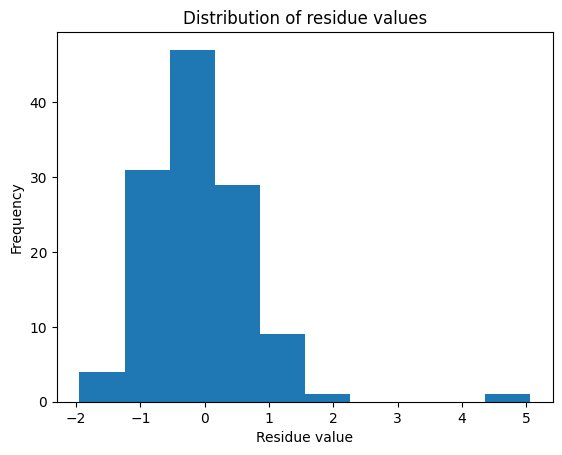

In [24]:
plt.hist(x  = predicted_df['Error'],)
plt.title('Distribution of residue values')
plt.xlabel('Residue value')
plt.ylabel('Frequency')

In [25]:
print('Error mean: ' + str(predicted_df['Error'].mean()))
print('Standard deviation: ' + str(predicted_df['Error'].std()))

Error mean: -0.07692235499197483
Standard deviation: 0.8202864388801969


In [26]:
standardized_errors = (predicted_df['Error'] - predicted_df['Error'].mean()) / predicted_df['Error'].std()
display(pd.DataFrame(standardized_errors))

,Error
145,-0.897908
322,0.431865
367,-0.475571
150,0.568047
34,-0.668857
...,...
438,0.940313
492,-0.860905
295,1.106345
45,0.104087


## Kolmogorov-Smirnov test

In [27]:
print(stats.kstest(standardized_errors, 'norm'))

KstestResult(statistic=0.07672043109868609, pvalue=0.4471402104700982, statistic_location=0.6024367025743939, statistic_sign=1)


## QQ Plot

It is used to comare the distribution of the data to the expected distribution.

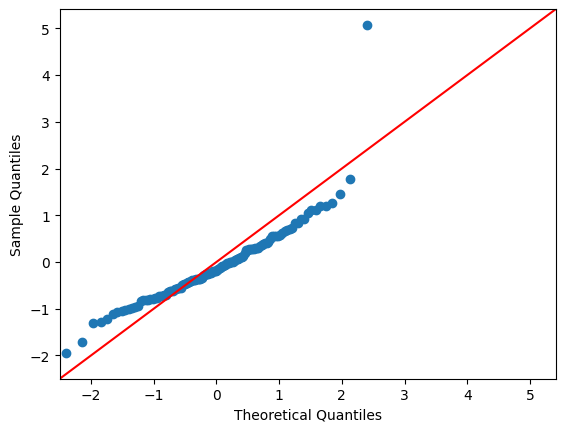

In [28]:
QQ = sm.qqplot(predicted_df['Error'], stats.norm, line='45')

---

## Citations
Bhatia, R. (n.d.). Data Science Job Salaries, V1.0. Retrieved August 11, 2023 from <a href="https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries">https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries</a>.

---
Francisco Javier Sánchez Panduro A01639832